In [ ]:
#!pip install kaggle
#!pip install --upgrade tensorflow
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#!unzip chest-xray-pneumonia.zip

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import os

# Data loading

In [3]:
batch_size = 32
img_size = (int(1857), int(1317))

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train/', 
                                                               image_size=img_size, batch_size=batch_size, 
                                                               color_mode='grayscale',)

test_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test/', 
                                                               image_size=img_size, batch_size=batch_size, 
                                                              color_mode='grayscale')
val_ds = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/val/',
                                                             image_size=img_size, batch_size=1, 
                                                             color_mode='grayscale')

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


# Preprocessing

In [5]:
resize_factor = 5

resize_and_rescale = Sequential([
  experimental.preprocessing.Resizing(int(img_size[0]/resize_factor), int(img_size[1]/resize_factor)),
  experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential(
    [
        experimental.preprocessing.RandomFlip("horizontal"),
        experimental.preprocessing.RandomRotation(factor=0.05),
        experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

Text(0.5, 1.0, 'Augmented image')

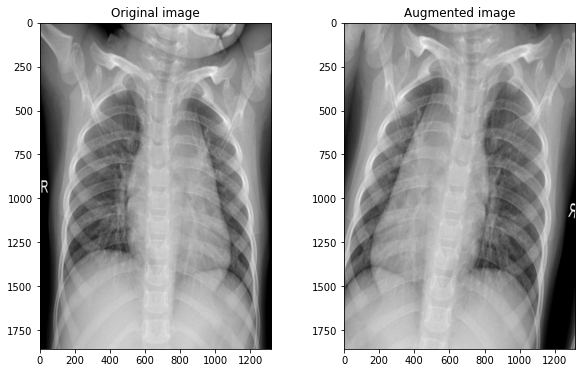

In [6]:
image, label = next(iter(train_ds))
image = image[0]

fig, ax = plt.subplots(ncols=2, figsize=(10, 6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(data_augmentation(tf.expand_dims(image, 0))[0], cmap='gray')
ax[1].set_title('Augmented image')

In [7]:
pneuomnia_size = len(os.listdir('chest_xray/train/PNEUMONIA'))
normal_size = len(os.listdir('chest_xray/train/NORMAL'))

weight_0 = (1 / normal_size)*(pneuomnia_size+normal_size)/2.0 
weight_1 = (1 / pneuomnia_size)*(pneuomnia_size+normal_size)/2.0

class_weights = {0: np.round(weight_0, 2), 1: np.round(weight_1, 2)}
class_weights

{0: 1.94, 1: 0.67}

# Model creation

In [ ]:
model = Sequential()

#model.add(InputLayer(input_shape=img_size))

model.add(resize_and_rescale)
model.add(data_augmentation)

#using SeparableConv2d gave slower training time; no increase in accuracy
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(BatchNormalization())


model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Flatten())

#using 1024 units increases learning time by 20% but doesn't improve accuracy
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.65))


model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))
#model.summary()

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'cnn_model',
    monitor="val_accuracy",
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience = 3, 
    verbose=1,
    factor=0.5, 
    min_lr=0.00001)

In [ ]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
h = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=test_ds, 
    callbacks=[checkpoint_callback, early_stopping, learning_rate_reduction],
    class_weight=class_weights
)

Epoch 1/30
163/163 [==============================] - 178s 1s/step - loss: 0.4713 - accuracy: 0.7851 - precision: 0.9421 - recall: 0.7560 - val_loss: 1.2339 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
INFO:tensorflow:Assets written to: cnn_model/assets
Epoch 2/30
163/163 [==============================] - 167s 998ms/step - loss: 0.2493 - accuracy: 0.9008 - precision: 0.9744 - recall: 0.8904 - val_loss: 2.0243 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/30
163/163 [==============================] - 167s 997ms/step - loss: 0.2102 - accuracy: 0.9199 - precision: 0.9747 - recall: 0.9169 - val_loss: 0.6537 - val_accuracy: 0.7276 - val_precision: 0.8374 - val_recall: 0.7000
INFO:tensorflow:Assets written to: cnn_model/assets
Epoch 4/30
163/163 [==============================] - 166s 995ms/step - loss: 0.2004 - accuracy: 0.9250 - precision: 0.9747 - recall: 0.9240 - val_loss: 1.0324 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_re

# Model results

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

ax[0].plot(h.history['loss'], label='Training')
ax[0].plot(h.history['val_loss'], label='Test')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(h.history['accuracy'], label='Training')
ax[1].plot(h.history['val_accuracy'], label='Test')
ax[1].legend()
ax[1].set_title('Accuracy')

#fig.savefig('cnn.png')

In [12]:
model_loaded = tf.keras.models.load_model('cnn_model')

print('Test set metrics:')
model_loaded.evaluate(test_ds)
print()
print('Validation set metrics: ')
model_loaded.evaluate(val_ds)
print()

Test set metrics:
20/20 [==============================] - 18s 643ms/step - loss: 0.1878 - accuracy: 0.9391 - precision: 0.9490 - recall: 0.9538
Validation set metrics: 
16/16 [==============================] - 0s 21ms/step - loss: 0.1911 - accuracy: 0.9375 - precision: 0.8889 - recall: 1.0000


[0.19105906784534454, 0.9375, 0.8888888955116272, 1.0]